# Procedure for generating VoC curves

1. Generate 120000 RFFs using `make_RFF`
2. For $t \in \{12, \dots, len(S)\}$:
   1. Standardize the RFFs by their standard deviation in the training sample i.e. sample $\{S_{t-T}, \dots S_{t-1}\}$ of the last $T$ observations, for $T \in \{12, 60, 120\}$. Also, standardize $S_{t}$ by the same standard deviation. Output `NaN` if $t < T$.
   2. Estimate the model by ridge regression with $P\in \{2,\dots, 12000\}$ and ridge shrinkage parameter $log_{10}(z) \in \{−3,\dots, 3\}$. In our case we are taking 9 values for $P$ and 7 values for $z$, so we have 63 models to estimate for each $t$.
3. From the sequence of out-of-sample predictions and strategy returns in step 2. calculate:
   1. average $||\hat{\beta}||^2$ across training samples,
   2. out-of-sample $R^2$ 
   3. out-of-sample average return of the timing strategy
   4. volatility of the timing strategy
   5. Sharpe ratio of the timing strategy


In the following subsections of the notebook we inspect each of the steps, check the results of each step and profile the code in each step to identify bottlenecks.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import datetime as dt

import sys
sys.path.append('..')

from src.visualization.visualize import plot_broken_x
from src.utils.utils import unpack_results

# 1. Load and unpack results into a multi-index dataframe

In [3]:
interim_data_path = "../data/interim/simulation_outputs_voc_solver"
preprocessed_data_path = "../data/processed/processed_data.csv"
save_path = "../reports/figures/curves_voc_solver"

In [4]:
with open(interim_data_path + "/config.json", 'r') as fp:
    config = json.load(fp)
    last_run_seed = config['last_run_seed']
    gamma = config['gamma']
    T_list = config['T_list']
    z_list = config['z_list']
    P_dict = config['P_dict']
    P_max = 12000
    delta_t = config['delta_t']

In [5]:
data = pd.read_csv(preprocessed_data_path, index_col=0, parse_dates=True)
dates = data.index[min(T_list):]

run_params_unpacking = (T_list, P_dict, z_list) 

In [6]:
interim_data = pd.read_csv('../data/interim/formatted_goyal_data.csv', index_col=0, parse_dates=True)
interim_data = interim_data.loc[interim_data.index > dt.datetime(1927, 1, 1)]

In [7]:
seed = 1
# load results
b = np.load(f"{interim_data_path}/beta_norm_sq/{seed:04}beta_norm_sq.npy")
r = np.load(f"{interim_data_path}/return_forecasts/{seed:04}return_forecasts.npy")
sr = np.load(f"{interim_data_path}/strategy_returns/{seed:04}strategy_returns.npy")

# unpack results
beta_norm_sq_df, return_forecasts_df, strategy_returns_df = unpack_results((b, r, sr), run_params_unpacking, dates)


# 2. Calculate performance metrics

In [8]:
# calculate metrics
# beta
mean_beta_norm_sq = beta_norm_sq_df.mean().unstack()
beta_norm = np.sqrt(mean_beta_norm_sq) # in VoC paper they plotted square root of norm of beta
beta_norm = beta_norm.reset_index()
beta_norm['c'] = beta_norm['P']/beta_norm['T']

# R2
realized_R = data.R.iloc[12:]
forecast_errors = return_forecasts_df.subtract(realized_R, axis=0)
R_sq = 1 - forecast_errors.var() / realized_R.var()
R_sq_temp = (R_sq
        .to_frame()
        .unstack()
        .droplevel(0, axis=1)
        .reset_index()
        )
R_sq_temp['c'] = R_sq_temp['P']/R_sq_temp['T']
R_sq_temp.head()

# expected returns
strategy_returns = strategy_returns_df.mean().unstack().reset_index()
strategy_returns['c'] = strategy_returns['P']/strategy_returns['T']
strategy_returns.head()

# volatility
strategy_vola = strategy_returns_df.std().unstack().reset_index()
strategy_vola['c'] = strategy_vola['P']/strategy_vola['T']

# sharpe ratio
sharpe_ratio = strategy_returns.copy()
sharpe_ratio.loc[:, z_list] = sharpe_ratio.loc[:, z_list] / strategy_vola.loc[:, z_list]

# information ratio

excess_wrt_market = strategy_returns_rescaled.subtract(interim_data.CRSP_SPvw, axis=0).mean().unstack().reset_index()
excess_wrt_market['c'] = excess_wrt_market['P']/excess_wrt_market['T']

var_of_excess_wrt_market = strategy_returns_rescaled.subtract(interim_data.CRSP_SPvw, axis=0).std().unstack().reset_index()

information_ratio = excess_wrt_market.copy()
information_ratio.loc[:, z_list] = excess_wrt_market.loc[:, z_list] / var_of_excess_wrt_market.loc[:, z_list]
information_ratio

if True:
    beta_norm_avg = beta_norm
    R_sq_avg = R_sq_temp
    strategy_returns_avg = strategy_returns
    strategy_vola_avg = strategy_vola


NameError: name 'strategy_returns_rescaled' is not defined

In [ ]:
data.head()

,dfy,infl,svar,de,lty,tms,tbl,dfr,dp,dy,ltr,ep,b/m,ntis,mr,R
date,,,,,,,,,,,,,,,,
1929-12-31,9.463101,0.000000,3.522218,-9.480124,17.946744,-0.267664,4.854900,-2.117184,-19.041125,-19.583009,1.892854,-15.096032,4.766296,5.174505,-2.037304,0.288126
1930-01-31,9.137888,0.000000,0.996113,-9.573097,18.694918,0.613196,4.226658,2.206750,-19.297847,-18.788349,-0.713609,-15.245790,4.647688,4.444831,0.457240,0.694734
1930-02-28,8.744785,-0.902839,0.141551,-9.047697,19.317084,0.133301,4.772245,0.913696,-19.925824,-19.125106,-0.459937,-16.004079,4.371450,3.996735,0.989528,0.274144
1930-03-31,8.262224,-0.912300,0.172508,-8.422173,19.120484,0.050347,4.769870,-0.453574,-20.320173,-19.749430,1.046632,-16.559002,4.351337,3.982363,0.437831,0.797222
1930-04-30,7.704174,-0.922001,0.152278,-7.642985,19.110364,0.665901,4.168087,0.442426,-21.040377,-20.137156,0.680915,-17.334023,4.527337,3.567818,1.219600,-0.185709


In [ ]:
# this data is not lagged or standardized
interim_data = pd.read_csv('../data/interim/formatted_goyal_data.csv', index_col=0, parse_dates=True)
interim_data = interim_data.loc[interim_data.index > dt.datetime(1927, 1, 1)]
interim_data.columns

Index(['Index', 'D12', 'E12', 'b/m', 'tbl', 'AAA', 'BAA', 'lty', 'ntis',
       'Rfree', 'infl', 'ltr', 'corpr', 'svar', 'csp', 'CRSP_SPvw',
       'CRSP_SPvwx', 'dfy', 'dfr', 'tms', 'dp', 'dy', 'ep', 'de',
       'tbill_rfree', 'mr', 'R'],
      dtype='object')

In [ ]:
interim_data.loc[:, ['Index', 'Rfree', 'CRSP_SPvw', 'CRSP_SPvwx', 'mr', 'R']]

,Index,Rfree,CRSP_SPvw,CRSP_SPvwx,mr,R
date,,,,,,
1927-01-31,13.21,0.0025,-0.002910,-0.005579,-0.002910,-0.005410
1927-02-28,13.84,0.0026,0.045522,0.040566,0.045522,0.042922
1927-03-31,13.93,0.0030,0.007324,0.002610,0.007324,0.004324
1927-04-30,14.17,0.0025,0.013021,0.010907,0.013021,0.010521
1927-05-31,14.91,0.0030,0.062353,0.057096,0.062353,0.059353
...,...,...,...,...,...,...
2022-08-31,3955.00,0.0019,-0.040305,-0.042052,-0.040305,-0.042205
2022-09-30,3585.62,0.0019,-0.091495,-0.092876,-0.091495,-0.093395
2022-10-31,3871.98,0.0023,0.080248,0.079196,0.080248,0.077948


In [ ]:
# this sigma is to be used for "destandardizing" the returns, i.e. multiplying by sigma
sigma_R = (interim_data.R**2).rolling(12).mean().apply(np.sqrt) 

In [ ]:
sigma_R.plot();

0.047527894307017815

In [ ]:
return_forecasts_df.loc[: "2022-12-31", :]

NameError: name 'return_forecasts_df' is not defined

In [ ]:
# these two dataframes are to be used 
return_forecasts_rescaled = return_forecasts_df.multiply(sigma_R, axis=0)
strategy_returns_rescaled = strategy_returns_df.multiply(sigma_R, axis=0)

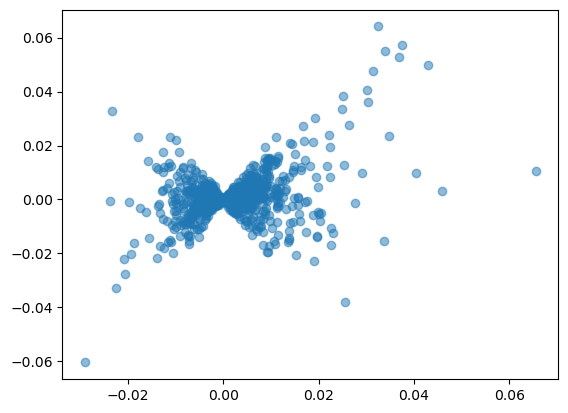

In [ ]:
plt.plot(return_forecasts_rescaled.loc[:,(120,12000,0.001)].values,
strategy_returns_rescaled.loc[:,(120,12000,0.001)].values, 'o', alpha=0.5)

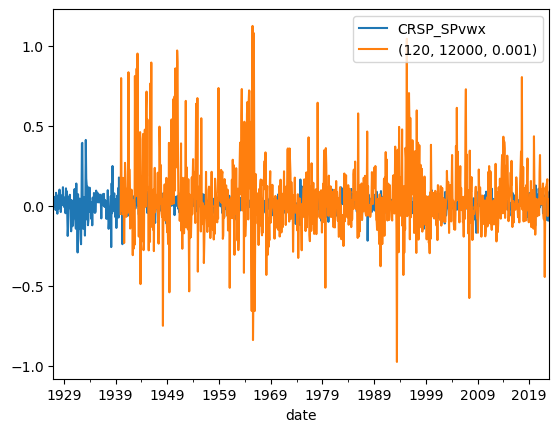

In [ ]:
interim_data.CRSP_SPvwx.plot()
return_forecasts_df.loc[:,(120,12000,0.001)].plot()
plt.legend()
return_forecasts_df

## Information Ratio


In [ ]:
excess_wrt_market = strategy_returns_rescaled.subtract(interim_data.CRSP_SPvw, axis=0).mean().unstack().reset_index()
excess_wrt_rfree = strategy_returns_rescaled.subtract(interim_data.Rfree, axis=0).mean().unstack().reset_index()

excess_wrt_market['c'] = excess_wrt_market['P']/excess_wrt_market['T']

var_of_excess_wrt_market = strategy_returns_rescaled.subtract(interim_data.CRSP_SPvw, axis=0).std().unstack().reset_index()

information_ratio = excess_wrt_market.copy()
information_ratio.loc[:, z_list] = excess_wrt_market.loc[:, z_list] / var_of_excess_wrt_market.loc[:, z_list]
information_ratio

z,T,P,0.001,0.01,0.1,1.0,10.0,100.0,1000.0,c
0,12,1,-0.177596,-0.177632,-0.177929,-0.178462,-0.177107,-0.176564,-0.176498,0.083333
1,12,3,-0.172799,-0.173204,-0.176178,-0.181626,-0.178277,-0.176703,-0.176512,0.250000
2,12,5,-0.138860,-0.140876,-0.152428,-0.171388,-0.176541,-0.176521,-0.176494,0.416667
3,12,9,-0.089280,-0.099256,-0.131161,-0.166378,-0.175727,-0.176410,-0.176483,0.750000
4,12,12,-0.033599,-0.068172,-0.120516,-0.159761,-0.173126,-0.175927,-0.176426,1.000000
5,12,15,-0.054946,-0.066150,-0.106884,-0.153330,-0.171420,-0.175703,-0.176403,1.250000
6,12,20,-0.103126,-0.105808,-0.121488,-0.153933,-0.170387,-0.175465,-0.176375,1.666667
7,12,30,-0.117951,-0.119235,-0.128246,-0.158094,-0.172767,-0.175825,-0.176425,2.500000
8,12,45,-0.150356,-0.150580,-0.152365,-0.160724,-0.171162,-0.175250,-0.176404,3.750000
9,12,90,-0.152379,-0.152460,-0.153155,-0.157096,-0.167149,-0.174089,-0.176210,7.500000


In [ ]:
excess_wrt_market = strategy_returns_rescaled.subtract(interim_data.CRSP_SPvw, axis=0).mean().unstack().reset_index()
excess_wrt_rfree = strategy_returns_rescaled.subtract(interim_data.Rfree, axis=0).mean().unstack().reset_index()

In [ ]:
xr_benchmark = strategy_returns_rescaled.subtract(interim_data.CRSP_SPvw, axis=0)
xr_strategy =  strategy_returns_rescaled.subtract(interim_data.Rfree, axis=0)

In [ ]:
xr_benchmark = interim_data.CRSP_SPvw
xr_strategy =  strategy_returns_rescaled

In [ ]:
xr_strategy

T                12                                                     \
P              1                                                         
z           0.001     0.010     0.100     1.000     10.000    100.000    
date                                                                     
1927-01-31       NaN       NaN       NaN       NaN       NaN       NaN   
1927-02-28       NaN       NaN       NaN       NaN       NaN       NaN   
1927-03-31       NaN       NaN       NaN       NaN       NaN       NaN   
1927-04-30       NaN       NaN       NaN       NaN       NaN       NaN   
1927-05-31       NaN       NaN       NaN       NaN       NaN       NaN   
...              ...       ...       ...       ...       ...       ...   
2022-08-31  0.005480  0.005421  0.004877  0.001988 -0.001161 -0.001819   
2022-09-30 -0.033726 -0.033439 -0.030838 -0.017757 -0.004773 -0.002213   
2022-10-31  0.011250  0.011129  0.010022  0.004456 -0.001075 -0.002167   
2022-11-30 -0.011660 -0.011580 -0.010859 -0.007246 -0.003685 -0.002985   
2022-12-31 -0.009239 -0.009182 -0.008663 -0.006152 -0.003802 -0.003354   

T                                                   ...       120            \
P                        3                          ...     6000              
z           1000.000  0.001     0.010     0.100     ...  10.000    100.000    
date                                                ...                       
1927-01-31       NaN       NaN       NaN       NaN  ...       NaN       NaN   
1927-02-28       NaN       NaN       NaN       NaN  ...       NaN       NaN   
1927-03-31       NaN       NaN       NaN       NaN  ...       NaN       NaN   
1927-04-30       NaN       NaN       NaN       NaN  ...       NaN       NaN   
1927-05-31       NaN       NaN       NaN       NaN  ...       NaN       NaN   
...              ...       ...       ...       ...  ...       ...       ...   
2022-08-31 -0.001892  0.028921  0.028417  0.024226  ...  0.000588 -0.000447   
2022-09-30 -0.001932 -0.042638 -0.042320 -0.039474  ...  0.001828 -0.001627   
2022-10-31 -0.002287  0.175537  0.168858  0.122598  ... -0.004002 -0.002450   
2022-11-30 -0.002909 -0.017104 -0.016926 -0.015363  ...  0.001504 -0.000762   
2022-12-31 -0.003305  0.011456  0.011571  0.012109  ... -0.007682 -0.004496   

T                                                                       \
P                        12000                                           
z           1000.000  0.001     0.010     0.100     1.000     10.000     
date                                                                     
1927-01-31       NaN       NaN       NaN       NaN       NaN       NaN   
1927-02-28       NaN       NaN       NaN       NaN       NaN       NaN   
1927-03-31       NaN       NaN       NaN       NaN       NaN       NaN   
1927-04-30       NaN       NaN       NaN       NaN       NaN       NaN   
1927-05-31       NaN       NaN       NaN       NaN       NaN       NaN   
...              ...       ...       ...       ...       ...       ...   
2022-08-31 -0.001631  0.000786  0.000786  0.000784  0.000762  0.000568   
2022-09-30 -0.001987 -0.005683 -0.005683 -0.005680 -0.005657 -0.005432   
2022-10-31 -0.002194 -0.004031 -0.004031 -0.004031 -0.004026 -0.003935   
2022-11-30 -0.002537 -0.001388 -0.001388 -0.001387 -0.001373 -0.001302   
2022-12-31 -0.003471 -0.004415 -0.004414 -0.004411 -0.004376 -0.004138   

T                               
P                               
z           100.000   1000.000  
date                            
1927-01-31       NaN       NaN  
1927-02-28       NaN       NaN  
1927-03-31       NaN       NaN  
1927-04-30       NaN       NaN  
1927-05-31       NaN       NaN  
...              ...       ...  
2022-08-31 -0.000351 -0.001519  
2022-09-30 -0.004015 -0.002333  
2022-10-31 -0.003076 -0.002357  
2022-11-30 -0.001580 -0.002513  
2022-12-31 -0.003740 -0.003449  

[1152 rows x 315 columns]

In [ ]:
idx = xr_benchmark.loc[:,(60,1,0.001)].dropna().index
# 1931-01-31
# 1935-01-31
# 1940-01-31 

In [ ]:
interim_data.CRSP_SPvw.loc[idx]

date
1935-01-31   -0.042368
1935-02-28   -0.036840
1935-03-31   -0.031454
1935-04-30    0.096493
1935-05-31    0.038135
                ...   
2022-08-31   -0.040305
2022-09-30   -0.091495
2022-10-31    0.080248
2022-11-30    0.054166
2022-12-31   -0.058784
Name: CRSP_SPvw, Length: 1056, dtype: float64

In [ ]:
xr_strategy.loc[:,(12,1,0.001)]

date
1927-01-31         NaN
1927-02-28         NaN
1927-03-31         NaN
1927-04-30         NaN
1927-05-31         NaN
                ...   
2022-08-31    0.005480
2022-09-30   -0.033726
2022-10-31    0.011250
2022-11-30   -0.011660
2022-12-31   -0.009239
Name: (12, 1, 0.001), Length: 1152, dtype: float64

In [ ]:
import statsmodels.api as sm

In [ ]:
indices = strategy_returns_rescaled.columns.to_list()
alpha = strategy_vola_avg.copy()
alpha.loc[:,z_list] = np.zeros_like(alpha.loc[:,z_list])
alpha_t_stat = alpha.copy()

In [ ]:
X = xr_benchmark.loc[:,indices[1]].dropna().values
Y = xr_strategy.loc[:,indices[1]].dropna().values
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
alpha = results.params[0]
alpha_t_stat = results.tvalues[0]

In [ ]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     95.43
Date:                Fri, 21 Jun 2024   Prob (F-statistic):           1.13e-21
Time:                        17:41:23   Log-Likelihood:                 3120.5
No. Observations:                1104   AIC:                            -6237.
Df Residuals:                    1102   BIC:                            -6227.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0024      0.000     -5.454      0.000      -0.003      -0.002
x1             0.0750      0.008      9.769      0.000       0.060       0.090
==============================================================================
Omnibus:                      401.841   Durbin-Watson:                   2.185
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15210.523
Skew:                          -0.974   Prob(JB):                         0.00
Kurtosis:                      21.080   Cond. No.                         17.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
results.tvalues[0]

-5.453596796527435

In [ ]:
indices = strategy_returns_rescaled.columns.to_list()
alpha = strategy_vola_avg.copy()
alpha.loc[:,z_list] = np.zeros_like(alpha.loc[:,z_list])
alpha_t_stat = alpha.copy()

for multi_index in indices:
    X = xr_benchmark.loc[:,multi_index].dropna()
    Y = xr_strategy.loc[:,multi_index].dropna()
    X = sm.add_constant(X)
    model = sm.OLS(Y,X)
    results = model.fit()

    P=multi_index[1]
    T=multi_index[0]
    z=multi_index[2]

    alpha.loc[(alpha.loc[:, 'P']==P) & (alpha.loc[:, 'T']==T), float(z)] = results.params.iloc[0]
    alpha_t_stat.loc[(alpha.loc[:, 'P']==P) & (alpha.loc[:, 'T']==T), float(z)] = results.tvalues.iloc[0]



In [ ]:
results.params.iloc[0]

-0.0028509979234014066

In [ ]:
Y

date
1940-01-31    0.000208
1940-02-29    0.000941
1940-03-31   -0.000048
1940-04-30   -0.000057
1940-05-31   -0.001387
                ...   
2022-08-31   -0.001519
2022-09-30   -0.002333
2022-10-31   -0.002357
2022-11-30   -0.002513
2022-12-31   -0.003449
Name: (120, 12000, 1000.0), Length: 996, dtype: float64

In [ ]:
alpha.loc[(alpha.loc[:, 'P']==3) & (alpha.loc[:, 'T']==12), 1.00]=1

In [ ]:
alpha

z,T,P,0.001,0.01,0.1,1.0,10.0,100.0,1000.0,c
0,12,1,-0.002383,-0.002391,-0.002455,-0.002676,-0.002693,-0.002667,-0.002664,0.083333
1,12,3,-0.001428,-0.001473,-0.001815,1.000000,-0.002750,-0.002674,-0.002664,0.250000
2,12,5,0.001104,0.000952,-0.000010,-0.001983,-0.002649,-0.002665,-0.002663,0.416667
3,12,9,0.005605,0.004345,0.001892,-0.001507,-0.002591,-0.002658,-0.002663,0.750000
4,12,12,0.006086,0.005035,0.002360,-0.001082,-0.002434,-0.002632,-0.002660,1.000000
5,12,15,0.005473,0.004987,0.002911,-0.000703,-0.002337,-0.002619,-0.002658,1.250000
6,12,20,0.003767,0.003587,0.002410,-0.000634,-0.002274,-0.002606,-0.002657,1.666667
7,12,30,0.002839,0.002759,0.002133,-0.000543,-0.002365,-0.002625,-0.002660,2.500000
8,12,45,0.000188,0.000167,-0.000008,-0.000939,-0.002244,-0.002589,-0.002658,3.750000
9,12,90,-0.000690,-0.000696,-0.000752,-0.001101,-0.002016,-0.002524,-0.002647,7.500000


In [ ]:
alpha = strategy_vola_avg.copy()
alpha.loc[:,z_list] = np.zeros_like(alpha.loc[:,z_list])
alpha_t_stat = alpha.copy()